In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from skimage.io import imread
from skimage.transform import resize
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm

import data_utils

# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

def randnorm(size):
    return np.random.normal(0, 1, size).astype('float32')


# Function to get label
def get_labels(batch):
    return get_variable(Variable(torch.from_numpy(batch['ts']).long()))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(torch.from_numpy(batch['images']))),
        'x_margin': get_variable(Variable(torch.from_numpy(batch['margins']))),
        'x_shape': get_variable(Variable(torch.from_numpy(batch['shapes']))),
        'x_texture': get_variable(Variable(torch.from_numpy(batch['textures'])))
    }

Running GPU.


In [2]:
current_directory = os.getcwd()

image_base_path = os.path.join(current_directory, 'images') #For the folder
image_path = os.path.join(current_directory,"images/*.jpg") #References all the image
image_paths = glob.glob(image_path) #glob glob
print("Total Observations:\t", len(image_paths))

train_path = os.path.join(current_directory,"train.csv")
test_path = os.path.join(current_directory,"test.csv")

# now loading the train.csv to find features for each training point
train = pd.read_csv(train_path)
train_images = [os.path.join(current_directory,"images/{}.jpg").format(i) for i in train.id.values]

# now loading the test.csv
test = pd.read_csv(test_path)

Total Observations:	 1584


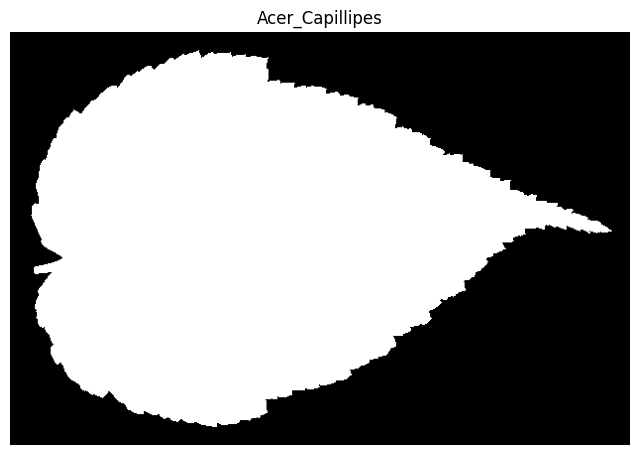

In [3]:
species = np.array(sorted(train.species.unique()))
species_examples = [np.random.choice(train[train.species == s].id.values) for s in species]

indexes = [image_paths.index(os.path.join(current_directory,"images\{}.jpg").format(i).format(i)) for i in species_examples]

# Display the first image
plt.figure(figsize=(8, 8))
image = imread(image_paths[indexes[0]], as_gray=True)
plt.imshow(image, cmap='gray')
plt.title("%s" % (species[0]))
plt.axis('off')
plt.show()

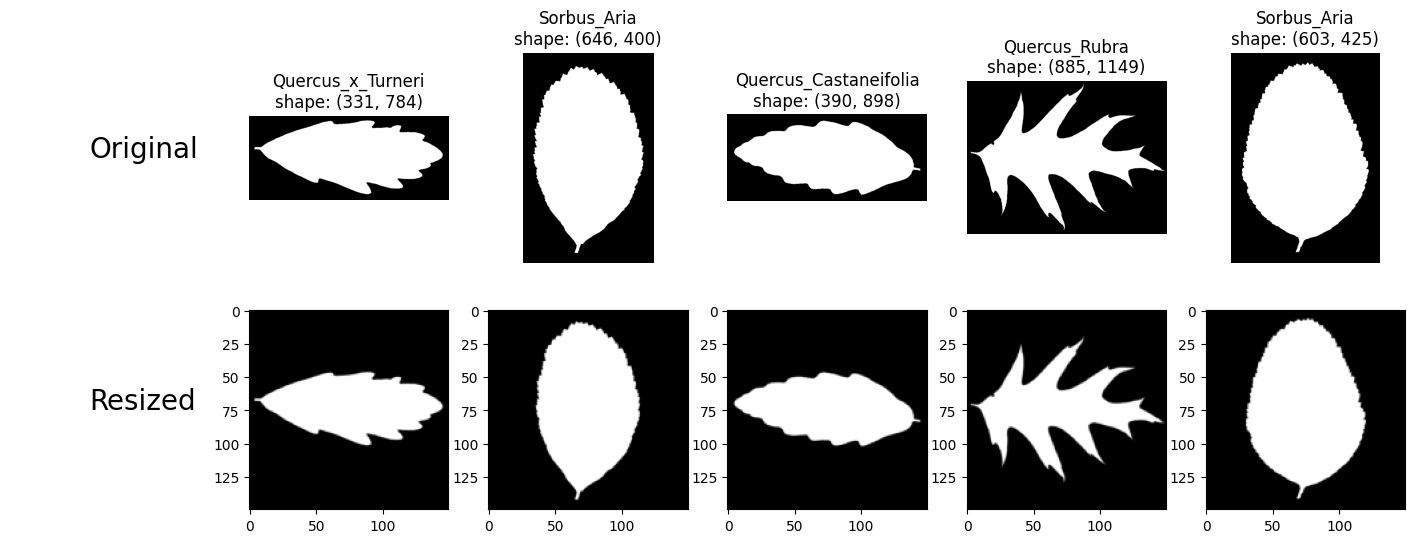

In [4]:
## Image pre-processing
image_size = (150, 150)  # <-- YOUR CODE HERE
#####
#The original images have a max pixel size of 1000x1000. 
# Resizing to small is essentially a low pass filter. If you go smaller than 32x32, a lot of details are lost. By 64x64 there are more details but the finer details are still lost. 
# When up to 128x128 most of the high frequenncy components are visible to the human eye.
# I will attempt to use 128x128
#####

# Amount of images
amount = 5
image_sample = np.random.choice(train_images, amount)

# Define figure size
fig = plt.figure(figsize=(18, 6))

# Save original images in the figure
ax = plt.subplot(2, amount + 1, 1)
txt = ax.text(0.4, 0.5, 'Original', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    plt.subplot(2, amount + 1, i + 2)
    image = imread(path, as_gray=True)    
    plt.imshow(image, cmap='gray')
    _id = int(path.split('/')[-1].split('.')[0])
    plt.title("{0}\nshape: {1}".format(train[train.id == _id].species.values[0], image.shape))
    plt.axis('off')
    
# Save resized images in the figure
ax = plt.subplot(2, amount + 1, len(image_sample) + 2)
txt = ax.text(0.4, 0.5, 'Resized', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    i += len(image_sample) + 3
    plt.subplot(2, amount + 1, i)
    image = imread(path, as_gray=True)
    image = data_utils.pad2square(image)  # Make the image square
    image = resize(image, output_shape=image_size, mode='reflect', anti_aliasing=True)  # resizes the image
    plt.imshow(image, cmap='gray')

# Show plot
plt.show()

In [5]:
X = train.values
species = X[:, 1:2]
margin = X[:, 2:66]
shape = X[:, 66:130]
texture = X[:, 130:]

In [6]:
# The image shape should be of the format (height, width, channels)
IMAGE_SHAPE = (100,100,1)   # <-- Your answer here
NUM_CLASSES =  99  # <-- Your answer here 

# For all three features types margin, shape, and texture, we have NUM_FEATURES for each type.
NUM_FEATURES = 64  # <-- Your answer here

In [7]:
TRAIN_PATH = train_path 
TEST_PATH = test_path
IMAGE_PATHS = glob.glob(image_path)

#train holds both X (input) and t (target/truth)
data = data_utils.load_data(train_path=TRAIN_PATH, 
                            test_path=TEST_PATH,
                            image_paths=IMAGE_PATHS,
                            image_shape=IMAGE_SHAPE[:2])

batch_size = 96 
dummy_batch_gen = data_utils.batch_generator(data, batch_size=batch_size, num_classes=NUM_CLASSES, num_iterations=5e3, seed=42)
train_batch = next(dummy_batch_gen.gen_train())
valid_batch, i = next(dummy_batch_gen.gen_valid())
test_batch, i = next(dummy_batch_gen.gen_test())

Loading training data
	0 of 990
	100 of 990
	200 of 990
	300 of 990
	400 of 990
	500 of 990
	600 of 990
	700 of 990
	800 of 990
	900 of 990
Loading test data
	0 of 594
	100 of 594
	200 of 594
	300 of 594
	400 of 594
	500 of 594


In [8]:
height, width, channels = IMAGE_SHAPE

# Convolutional Layer Parameters
conv_out_channels1 = 16
conv_out_channels2 = 32
conv_out_channels3 = 64

# Feature sizes for x_margin, x_shape, and x_texture
feature_size = 64

# Calculate the output size after all convolutional layers
final_conv_output_size = (height // 8) * (width // 8) * conv_out_channels3

# Total features concatenated before the dense layer
features_cat_size = final_conv_output_size + 3 * feature_size 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Convolutional Layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=conv_out_channels1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(conv_out_channels1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.2),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(in_channels=conv_out_channels1, out_channels=conv_out_channels2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(conv_out_channels2),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.2),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(in_channels=conv_out_channels2, out_channels=conv_out_channels3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(conv_out_channels3),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.2),
            nn.MaxPool2d(2, 2)

        )

        # Dense Layers
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features=features_cat_size, out_features=128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.2),
            nn.Linear(128, NUM_CLASSES)
        )

    def forward(self, x_img, x_margin, x_shape, x_texture):
        x_img = torch.permute(x_img, (0, 3, 1, 2))
        x_img = self.conv(x_img)
        x_img = torch.flatten(x_img, 1)

        # Directly concatenate features without using LSTM
        features = torch.cat([x_img, x_margin, x_shape, x_texture], dim=1)

        # Pass through dense layers
        out = self.fc(features)
        return {'out': out}

# Create the model instance
net = Net()
if use_cuda:
    net.cuda()
print(net)


Net(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.15, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.15, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): Dropout(p=0.15, inplace=False)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

In [9]:
LEARNING_RATE = 1e-3 #0.001
WEIGHT_DECAY= 1e-5

criterion = nn.CrossEntropyLoss()        
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)



In [10]:
_img_shape = tuple([batch_size] + list(IMAGE_SHAPE))

_feature_shape = (batch_size, NUM_FEATURES)

# dummy data
_x_image = get_variable(Variable(torch.from_numpy(randnorm(_img_shape))))
_x_margin = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_shape = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_texture = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))


# test the forward pass
output = net(x_img=_x_image, x_margin=_x_margin, x_shape=_x_shape, x_texture=_x_texture)
output['out']

tensor([[ 0.3008,  0.2713,  0.1412,  ..., -0.4284,  0.0671, -0.2494],
        [-0.1742, -0.4333,  0.4591,  ...,  0.0595, -0.1063, -0.2060],
        [-0.1325, -0.1981,  0.5566,  ..., -0.2992, -0.2069, -0.3148],
        ...,
        [ 0.5382, -0.1818,  0.5315,  ..., -0.3066, -0.0711, -0.2179],
        [ 0.2713, -0.8022,  1.2626,  ..., -0.1670,  0.1830, -0.3498],
        [-0.2023, -0.0027,  0.4893,  ...,  0.8143, -0.6063, -0.0695]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [11]:
# Setup settings for training 
VALIDATION_SIZE = 0.1 # 0.1 is ~ 100 samples for validation
max_iter = 200
log_every = 1
eval_every = 1

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []
latest_val_acc = 0.0


# Generate batches
batch_gen = data_utils.batch_generator(data,
                                       batch_size=batch_size,
                                       num_classes=NUM_CLASSES,
                                       num_iterations=max_iter,
                                       seed=42,
                                       val_size=VALIDATION_SIZE)

# Train network
net.train()
progress_bar = tqdm(range(max_iter), desc="Training")

for i, batch_train in enumerate(batch_gen.gen_train()):
    if i % eval_every == 0:
        
        # Do the validaiton
        net.eval()
        val_losses, val_accs, val_lengths = 0, 0, 0
        for batch_valid, num in batch_gen.gen_valid():
            output = net(**get_input(batch_valid))
            labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
            val_losses += criterion(output['out'], labels_argmax) * num
            val_accs += accuracy(output['out'], labels_argmax) * num
            val_lengths += num

        # Divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        valid_loss.append(get_numpy(val_losses))
        valid_accs.append(get_numpy(val_accs))
        valid_iter.append(i)
        net.train()
    
    # Train network
    output = net(**get_input(batch_train))
    labels_argmax = torch.max(get_labels(batch_train), 1)[1]
    batch_loss = criterion(output['out'], labels_argmax)
    
    train_iter.append(i)
    train_loss.append(float(get_numpy(batch_loss)))
    train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

    # Update progress bar
    progress_bar.set_postfix({'training_loss': '{:.3f}'.format(train_loss[-1]), 
                              'training_acc': '{:.3f}'.format(train_accs[-1]), 
                              'validation_acc': '{:.3f}'.format(valid_accs[-1])})
    progress_bar.update()

    if max_iter < i:
        break

progress_bar.close()

   

Training:  60%|██████    | 120/200 [04:56<03:17,  2.46s/it, training_loss=1.637, training_acc=0.604, validation_acc=0.545]

In [ ]:
print(valid_accs[-1])

fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(train_iter, train_loss, label='train_loss')
plt.plot(valid_iter, valid_loss, label='valid_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_iter, train_accs, label='train_accs')
plt.plot(valid_iter, valid_accs, label='valid_accs')
plt.legend()
plt.show()
clear_output(wait=True)

In [ ]:
valid_loss_floats = [float(acc) for acc in valid_loss]
train_loss_floats = [float(acc) for acc in train_loss]

valid_accs_floats = [float(acc) for acc in valid_accs]
train_accs_floats = [float(acc) for acc in train_accs]



# Calculate the step size for 10% of the list length
step_size_valid_loss = len(valid_loss_floats) // 10
step_size_train_loss = len(train_loss_floats) // 10

step_size_valid_accs = len(valid_accs_floats) // 10
step_size_train_accs = len(train_accs_floats) // 10

print("Loss: Train|Vali")
print([f"{acc:.3f}" for idx, acc in enumerate(train_loss_floats) if idx % step_size_train_loss == 0])
print([f"{acc:.3f}" for idx, acc in enumerate(valid_loss_floats) if idx % step_size_valid_loss == 0])


print("Accuracy: Train|Vali")
print([f"{acc:.3f}" for idx, acc in enumerate(train_accs_floats) if idx % step_size_train_accs == 0])
print([f"{acc:.3f}" for idx, acc in enumerate(valid_accs_floats) if idx % step_size_valid_accs == 0])


In [ ]:
# GET PREDICTIONS
# containers to collect ids and predictions
ids_test, preds_test = [], []
net.eval()
# run like with validation
for batch_test, num in batch_gen.gen_test():
    output = net(**get_input(batch_test))
    y_out = output['out'].data.cpu()  # Move tensor to CPU

    ids_test += batch_test['ids']
    if num != len(y_out):
        # in case of the last batch, num will be less than batch_size
        y_out = y_out[:num]
    preds_test.append(y_out.numpy())  # Convert tensor to numpy array

preds_test = np.concatenate(preds_test, axis=0)
assert len(ids_test) == len(preds_test)


In [ ]:
preds_df = pd.DataFrame(preds_test, columns=data.le.classes_)
ids_test_df = pd.DataFrame(ids_test, columns=["id"])
submission = pd.concat([ids_test_df, preds_df], axis=1)
submission.to_csv(current_directory + 'submission.csv', index=False)

# below prints the submission, can be removed and replaced with code block below
submission.head(5)